In [1]:
# --- Setup (paths + helpers) ---
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


IMAGES_DIR = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
OUT_DIR    = "./v26_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_EXTS = (".jpg", ".jpeg", ".png", ".tif", ".tiff")

def list_images(folder):
    items = []
    for ext in IMG_EXTS:
        items += glob.glob(os.path.join(folder, f"*{ext}"))
    items = sorted(items)
    if not items:
        raise FileNotFoundError(f"No images found in {folder}")
    return items

def load_bgr(path, max_side=1024):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if max_side is not None:
        h, w = img.shape[:2]
        sc = max(h, w) / float(max_side)
        if sc > 1.0:
            img = cv2.resize(img, (int(w/sc), int(h/sc)), interpolation=cv2.INTER_AREA)
    return img

def save_mask(path, mask_u8):
    cv2.imwrite(path, mask_u8)

def save_overlay(path, img_bgr, mask_u8, alpha=0.45):
    m = (mask_u8 > 127)
    over = img_bgr.copy()
    over[m] = (0,255,0)
    vis = cv2.addWeighted(img_bgr, 1.0, over, alpha, 0)
    cv2.imwrite(path, vis)


In [2]:
# --- Vegetation indices: ExG, NGRDI, VARI ---

def to_float01(img_bgr: np.ndarray) -> np.ndarray:
    return img_bgr.astype(np.float32) / 255.0

def norm_rgb(img_bgr: np.ndarray):
    b,g,r = cv2.split(to_float01(img_bgr))
    s = b+g+r + 1e-6
    return r/s, g/s, b/s

def exg(img_bgr: np.ndarray) -> np.ndarray:
    r_n,g_n,b_n = norm_rgb(img_bgr)
    return 2*g_n - r_n - b_n

def ngrdi(img_bgr: np.ndarray) -> np.ndarray:
    b,g,r = cv2.split(to_float01(img_bgr))
    return (g - r) / (g + r + 1e-6)

def vari(img_bgr: np.ndarray) -> np.ndarray:
    b,g,r = cv2.split(to_float01(img_bgr))
    return (g - r) / (g + r - b + 1e-6)


In [3]:
def regions_to_green_mask_refined(
    img_bgr: np.ndarray,
    labels: np.ndarray,
    hue_range=(35, 95),      #tighter green
    min_s: int = 35,
    min_v: int = 25,
    exg_region_pct: float = 75.0,   #percentile inside region
    region_score_pct: float = 70.0  #global percentile over region scores
) -> np.ndarray:
    """
    Robust region-wise vegetation decision:
    - region features: ExG percentile, %greenish pixels (HSV), Lab-a*, mean S, mean V
    - green score = w · features (with penalty on low-V)
    - select regions with score >= percentile over all region scores (adaptive)
    """
    #precompute per-pixel features
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = hsv[...,0].astype(np.float32), hsv[...,1].astype(np.float32), hsv[...,2].astype(np.float32)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    A = lab[...,1]  # 'a*' channel (green < 128 if uint8; after float32 conversion, compare to mean-128)

    #normalize Lab-a* around 0: OpenCV LAB is 0..255, center is 128
    A0 = A - 128.0

    b, g, r = cv2.split(img_bgr.astype(np.float32))
    exg_px  = 2*g - r - b

    k = int(labels.max()) + 1
    scores = np.zeros(k, np.float32)

    #region stats
    for rid in range(k):
        sel = (labels == rid)
        if not np.any(sel):
            scores[rid] = -1e9
            continue

        # 1) ExG robust: percentile inside region
        exg_p = np.percentile(exg_px[sel], exg_region_pct)

        # 2) greenish ratio (HSV)
        greenish = (H[sel] >= hue_range[0]) & (H[sel] <= hue_range[1]) & (S[sel] >= min_s) & (V[sel] >= min_v)
        green_ratio = float(greenish.mean())

        # 3) Lab-a* mean (more negative => greener)
        a_mean = float(A0[sel].mean())

        # 4) S and V means
        s_mean = float(S[sel].mean())
        v_mean = float(V[sel].mean())

        # Build a green score (weights tuned to favor natural greens)
        # Normalize terms roughly by expected ranges to keep them comparable
        # exg_p (unbounded) -> scale by robust std on-the-fly
        scores[rid] = (
            0.45 * (exg_p) +
            0.35 * (green_ratio * 255.0) +     # S,V in [0..255], scale green_ratio similarly
            0.25 * (-a_mean) +                 # negative a* is green => minus sign
            0.15 * (s_mean) -
            0.20 * max(0.0, 50.0 - v_mean)     # penalize very low V (shadows)
        )

    #adaptive threshold over region scores
    thr = np.percentile(scores[scores > -1e8], region_score_pct)
    mask = scores[labels] >= thr

    #small cleanup
    return mask.astype(bool)


In [4]:
# ================== SRM (auto-Q) — self-contained block ==================
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- SRM core (4-neighborhood) ----------
class UnionFind:
    def __init__(self, n: int):
        self.parent = np.arange(n, dtype=np.int32)
        self.size   = np.ones(n, dtype=np.int32)
    def find(self, x: int) -> int:
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x
    def union(self, a: int, b: int) -> int:
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return ra
        if self.size[ra] < self.size[rb]:
            ra, rb = rb, ra
        self.parent[rb] = ra
        self.size[ra]  += self.size[rb]
        return ra

def _edges_4n(h: int, w: int) -> np.ndarray:
    """Build 4-neighborhood edge list (p<q)."""
    idx = np.arange(h*w, dtype=np.int32).reshape(h, w)
    E = []
    if w > 1: E.append(np.stack([idx[:, :-1].ravel(), idx[:,  1:].ravel()], 1))
    if h > 1: E.append(np.stack([idx[:-1, :].ravel(), idx[1:,  :].ravel()], 1))
    edges = np.concatenate(E, 0)
    p, q = edges[:,0], edges[:,1]
    swap = p > q
    edges[swap,0], edges[swap,1] = q[swap], p[swap]
    return edges

def _gaussian_presmooth(img_rgb: np.ndarray, sigma_ratio: float = 0.0035) -> np.ndarray:
    """Light blur to reduce tiny texture-driven oversegmentation."""
    h, w = img_rgb.shape[:2]
    k = max(3, int(min(h, w) * sigma_ratio) | 1)
    return cv2.GaussianBlur(img_rgb, (k, k), 0)

def srm_segment_rgb(img_rgb: np.ndarray, Q: float, delta: float = 0.125) -> np.ndarray:
    """
    Statistical Region Merging on RGB image.
    Smaller Q => more merges => fewer regions. Larger Q => more regions.
    Returns label image (H,W) with labels in [0..K-1].
    """
    img = img_rgb.astype(np.float32)
    h, w = img.shape[:2]; n = h*w
    flat = img.reshape(-1, 3)

    edges = _edges_4n(h, w)
    p, q = edges[:,0], edges[:,1]
    diff = np.max(np.abs(flat[p] - flat[q]), axis=1)     #edge weight = max channel diff
    order = np.argsort(diff)

    uf = UnionFind(n)
    sum_rgb = flat.copy()

    g = 256.0
    log_term = math.log(6.0 * n / max(delta, 1e-12))
    def tau(sp, sq):
        return math.sqrt((g*g/(2.0*Q)) * (1.0/max(sp,1) + 1.0/max(sq,1)) * log_term)

    for e in order:
        a, b   = p[e], q[e]
        ra, rb = uf.find(a), uf.find(b)
        if ra == rb: continue
        sa, sb = uf.size[ra], uf.size[rb]
        ma, mb = sum_rgb[ra]/sa, sum_rgb[rb]/sb
        t = tau(sa, sb)
        if (abs(ma[0]-mb[0]) <= t and abs(ma[1]-mb[1]) <= t and abs(ma[2]-mb[2]) <= t):
            rc = uf.union(ra, rb)
            sum_rgb[rc] = sum_rgb[ra] + sum_rgb[rb]

    roots = np.array([uf.find(i) for i in range(n)], np.int32)
    _, labels = np.unique(roots, return_inverse=True)
    return labels.reshape(h, w)

# ---------- Auto-Q (region density target) ----------
def auto_srm_Q(img_rgb: np.ndarray,
               detail: str = "more",
               q_min: float = 8.0, q_max: float = 256.0,
               steps: int = 8, preview_side: int = 512) -> float:
    """
    Choose Q so that region density (regions per megapixel) fits the requested detail.
      'coarse'  -> fewer regions
      'default' -> baseline
      'more'    -> a bit more regions (recommended here)
      'fine'    -> many regions
    """
    density = {
        "coarse":  (60, 180),
        "default": (90, 240),
        "more":    (130, 330),
        "fine":    (180, 480),
    }.get(detail, (130, 330))

    h, w = img_rgb.shape[:2]
    mpx = (h*w) / 1e6
    targ_min = max(120, int(density[0] * mpx))
    targ_max = int(density[1] * mpx)

    #preview resize
    sc = max(h, w) / float(preview_side)
    if sc > 1.0:
        prev = cv2.resize(img_rgb, (int(w/sc), int(h/sc)), interpolation=cv2.INTER_AREA)
    else:
        prev = img_rgb.copy()

    Q_grid = np.geomspace(q_min, q_max, steps)
    best_Q, best_err = Q_grid[0], 1e18
    for Q in Q_grid:
        pre = _gaussian_presmooth(prev, sigma_ratio=0.0035 if detail in ["more","fine"] else 0.0040)
        lbl = srm_segment_rgb(pre, Q=float(Q))
        r = int(lbl.max()) + 1
        if targ_min <= r <= targ_max:
            return float(Q)
        err = min(abs(r - targ_min), abs(r - targ_max))
        if err < best_err:
            best_err, best_Q = err, float(Q)
    return float(best_Q)

# ---------- Visualization helper ----------
def colorize_labels(labels: np.ndarray, seed: int = 0) -> np.ndarray:
    """Random color per region id for quick visual check."""
    h, w = labels.shape
    k = int(labels.max()) + 1
    rng = np.random.default_rng(seed)
    lut = rng.integers(0, 255, size=(k, 3), dtype=np.uint8)
    return lut[labels]

# ---------- Public API ----------
def apply_srm(image_rgb: np.ndarray, detail: str = "more") -> np.ndarray:
    """
    Apply SRM with auto-Q (no manual tuning).
    Input can be uint8 RGB or float in [0,1]. Returns labels (H,W).
    """
    if image_rgb.dtype != np.uint8:
        img = np.clip(image_rgb, 0, 1)
        if img.max() <= 1.0:
            image_rgb = (img * 255.0).astype(np.uint8)
        else:
            image_rgb = np.clip(image_rgb, 0, 255).astype(np.uint8)

    Q = auto_srm_Q(image_rgb, detail=detail)
    pre = _gaussian_presmooth(image_rgb, sigma_ratio=0.0035 if detail in ["more","fine"] else 0.0040)
    labels = srm_segment_rgb(pre, Q=Q)
    return labels

# ----------Sobel (standalone, cv2-based) ----------
def sobel_magnitude(gray01: np.ndarray) -> np.ndarray:
    """Sobel magnitude in [0,1] using OpenCV (no scipy needed)."""
    gx = cv2.Sobel(gray01, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray01, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx*gx + gy*gy)
    return mag / (mag.max() + 1e-6)

# ----------preview: Original | SRM | Sobel ----------
def preview_srm(image_path: str, max_side: int = 1024, detail: str = "more"):
    """
    Shows Original, SRM labels (colorized), and Sobel magnitude.
    Uses your load_bgr if available; otherwise falls back to cv2.imread.
    """
 
    if "load_bgr" in globals():
        img_bgr = load_bgr(image_path, max_side=max_side)
    else:
        img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise ValueError(f"Cannot read {image_path}")
        if max_side is not None:
            h, w = img_bgr.shape[:2]
            sc = max(h, w) / float(max_side)
            if sc > 1.0:
                img_bgr = cv2.resize(img_bgr, (int(w/sc), int(h/sc)), interpolation=cv2.INTER_AREA)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    #SRM (auto-Q)
    srm_labels = apply_srm(img_rgb, detail=detail)
    srm_vis = colorize_labels(srm_labels)

    # Sobel magnitude
    gray01 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    sob = sobel_magnitude(gray01)

    
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.imshow(img_rgb); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(srm_vis); plt.title(f"SRM (auto-Q, detail='{detail}')"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(sob, cmap="gray"); plt.title("Sobel magnitude"); plt.axis("off")
    plt.tight_layout(); plt.show()
# ============================================================================



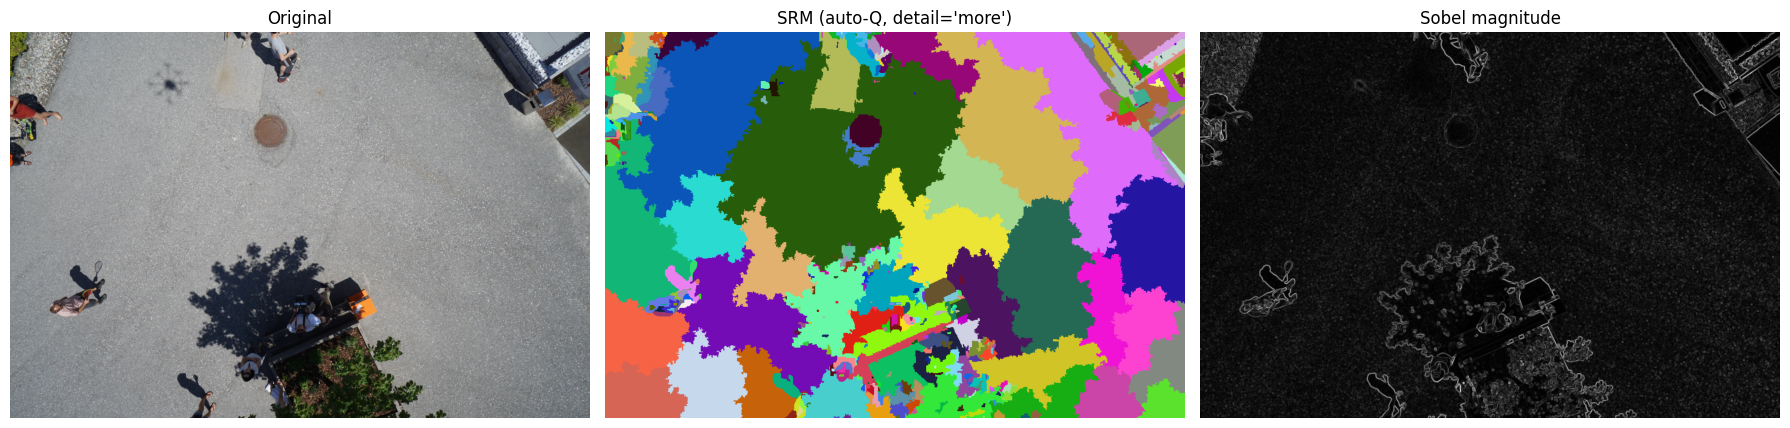

In [5]:
image_paths = list_images(IMAGES_DIR)
preview_srm(image_paths[0], max_side=1024, detail="more") 

#as we can see below, this SRM implmentation does not work properly. 
#best results are obtained if we set manually Q value to a lower value.

In [6]:
# --- Utilities for this preview ---
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#If you already have these, keep yours; else this loader is fine
def list_images(folder, exts=(".jpg",".jpeg",".png",".tif",".tiff")):
    from glob import glob
    items = []
    for e in exts:
        items += glob(os.path.join(folder, f"*{e}"))
    return sorted(items)

def load_bgr(path, max_side=1024):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if max_side is not None:
        h, w = img.shape[:2]
        sc = max(h, w) / float(max_side)
        if sc > 1.0:
            img = cv2.resize(img, (int(w/sc), int(h/sc)), interpolation=cv2.INTER_AREA)
    return img

def compute_sobel_magnitude(gray01: np.ndarray) -> np.ndarray:
    """Sobel magnitude in [0,1] (float32) from a grayscale image in [0,1]."""
    gx = cv2.Sobel(gray01, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray01, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx*gx + gy*gy)
    return mag / (mag.max() + 1e-6)

def preprocess_image(image_path, max_side=1024):
    """
    Returns:
      img_rgb01: RGB float in [0,1], shape (H,W,3)  <-- compatibile con apply_srm
      edges_u8 : Sobel magnitude uint8 [0..255], shape (H,W)
    """
    img_bgr = load_bgr(image_path, max_side=max_side)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb01 = img_rgb.astype(np.float32) / 255.0

    gray01 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0
    sob = compute_sobel_magnitude(gray01)
    edges_u8 = (sob * 255).astype(np.uint8)
    return img_rgb01, edges_u8


In [7]:
##other approach
from skimage.segmentation import felzenszwalb
import numpy as np

def apply_srm(image):
    """
    'SRM' baseline using Felzenszwalb segmentation.
    Expects image in [0,1] float (H,W,3). Returns label map (H,W) int.
    """
    image = (image * 255).astype(np.uint8)  #compatibility with felzenszwalb
    segmented = felzenszwalb(image, scale=500, sigma=0.8, min_size=200)
    return segmented


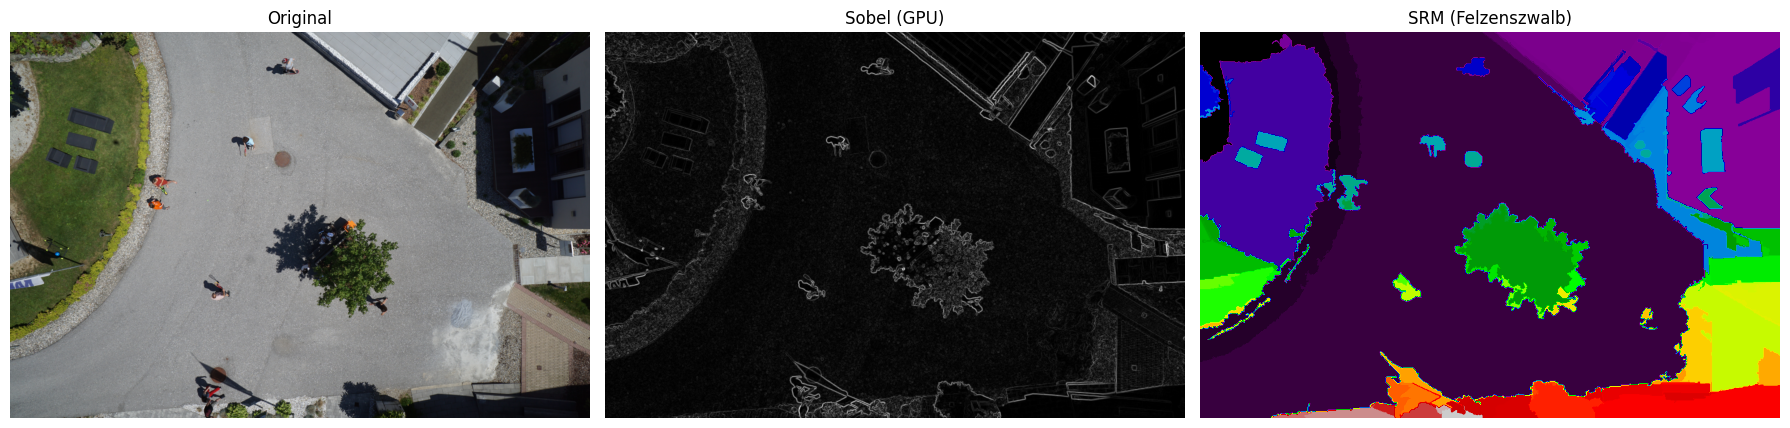

In [8]:
sample_image, sample_edges = preprocess_image(os.path.join(IMAGES_DIR, image_paths[2]))
srm_labels = apply_srm(sample_image)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1); plt.imshow(sample_image); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(sample_edges, cmap="gray"); plt.title("Sobel (GPU)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(srm_labels, cmap="nipy_spectral"); plt.title("SRM (Felzenszwalb)"); plt.axis("off")
plt.tight_layout(); plt.show()


In [9]:
###---- kmeans + sobel ----###

In [10]:
# ---v2.6 implementation (KMeans and Sobel) ---

import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.morphology import closing, disk
from scipy.ndimage import sobel

def compute_ndvi(image):
    b, g, r = cv2.split(image.astype(np.float32))
    ndvi = (g - r) / (g + r + 1e-6)
    return (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())

def compute_exg(image):
    b, g, r = cv2.split(image.astype(np.float32))
    return 2 * g - r - b

def compute_sobel_magnitude(gray):
    dx = sobel(gray, axis=1)
    dy = sobel(gray, axis=0)
    magnitude = np.hypot(dx, dy)
    return (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())

def generate_mask(image, clusters=2):
    ndvi = compute_ndvi(image)
    exg = compute_exg(image)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0] / 180.0

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    sobel_mag = compute_sobel_magnitude(gray)

    # Feature matrix
    features = np.stack([
        ndvi.flatten(),
        exg.flatten(),
        hue.flatten(),
        sobel_mag.flatten()
    ], axis=1)

    #KMeans segmentation
    kmeans = KMeans(n_clusters=clusters, random_state=42).fit(features)
    labels = kmeans.labels_.reshape(image.shape[:2])

    #pick cluster with highest (NDVI + Sobel)
    scores = [ndvi[labels == i].mean() + sobel_mag[labels == i].mean() for i in range(clusters)]
    veg_cluster = np.argmax(scores)

    #binary mask
    mask = (labels == veg_cluster).astype(np.uint8)
    mask = closing(mask, disk(5))
    return (mask * 255).astype(np.uint8)


In [11]:
# --- Preview utility: show Original, SRM, Sobel, KMeans mask ---
def _colorize_labels(labels: np.ndarray, seed: int = 0) -> np.ndarray:
    """Random color per label id (fallback if you don't already have colorize_labels)."""
    h, w = labels.shape
    k = int(labels.max()) + 1
    rng = np.random.default_rng(seed)
    lut = rng.integers(0, 255, size=(k, 3), dtype=np.uint8)
    return lut[labels]

def preview_v26(image_path, clusters=2, max_side=1024, save=False):
    #load
    img = load_bgr(image_path, max_side=max_side)

    #SRM (prefer srm_auto_pipeline if present, else felzenszwalb fallback)
    try:
        out = srm_auto_pipeline(img)  #expected keys: 'labels' or 'mask'
        if "labels" in out:
            srm_vis = _colorize_labels(out["labels"])
        else:
            srm_vis = (out["mask"].astype(np.uint8) * 255)
    except Exception:
        #fallback SRM-like oversegmentation for visualization
        try:
            from skimage.segmentation import felzenszwalb
            lbl = felzenszwalb(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
                               scale=600, sigma=1.0, min_size=250)
            srm_vis = _colorize_labels(lbl)
        except Exception:
            #last resort: show a blank image
            srm_vis = np.zeros_like(img)

    #Sobel magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
    sob  = compute_sobel_magnitude(gray)

    #KMeans mask (v2.6 function)
    mask_u8 = generate_mask(img, clusters=clusters)

    #stats
    coverage = (mask_u8 > 127).mean()
    print(f"[{os.path.basename(image_path)}] clusters={clusters} | mask coverage={coverage:.4f}")
    print(f"Sobel stats -> min={sob.min():.4f}  max={sob.max():.4f}  mean={sob.mean():.4f}")

    #plot: Original | SRM | Sobel | KMeans mask
    plt.figure(figsize=(18,6))
    plt.subplot(1,4,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Image"); plt.axis("off")
    if srm_vis.ndim == 2:  #binary
        plt.subplot(1,4,2); plt.imshow(srm_vis, cmap="gray"); plt.title("SRM"); plt.axis("off")
    else:
        plt.subplot(1,4,2); plt.imshow(cv2.cvtColor(srm_vis, cv2.COLOR_BGR2RGB)); plt.title("SRM"); plt.axis("off")
    plt.subplot(1,4,3); plt.imshow(sob, cmap="gray"); plt.title("Sobel magnitude"); plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(mask_u8, cmap="gray"); plt.title("KMeans mask (v2.6)"); plt.axis("off")
    plt.tight_layout(); plt.show()

    #optional save
    if save:
        name = os.path.splitext(os.path.basename(image_path))[0]
        save_mask(os.path.join(OUT_DIR, f"{name}_v26.png"), mask_u8)
        save_overlay(os.path.join(OUT_DIR, f"{name}_overlay.png"), img, mask_u8)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[000.jpg] clusters=2 | mask coverage=0.0267
Sobel stats -> min=0.0000  max=1.0000  mean=0.0756


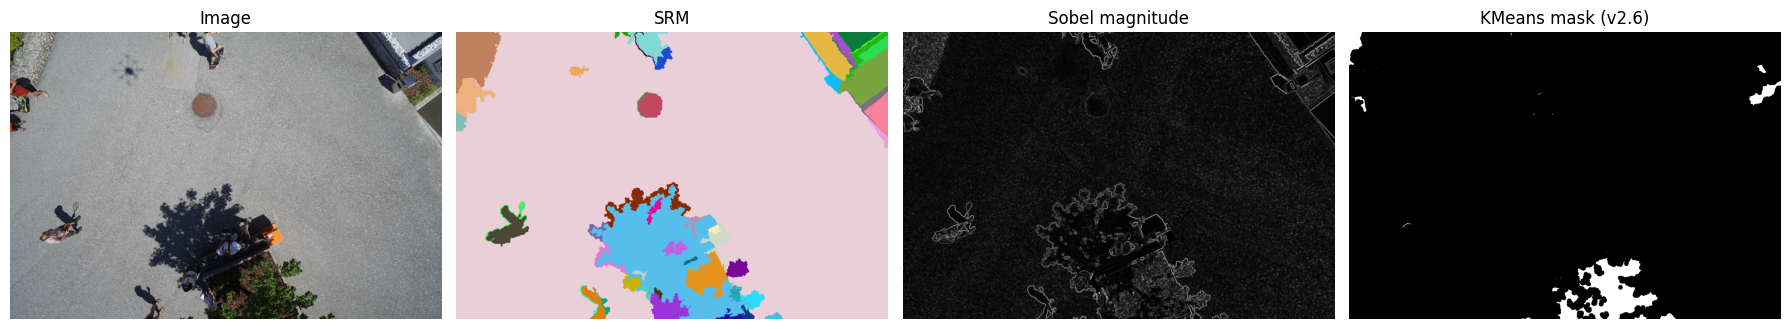

In [12]:
# --- Run a few examples ---
image_paths = list_images(IMAGES_DIR)

#try one image (change index if you want)
preview_v26(image_paths[0], clusters=2, max_side=1024, save=False)

#optionally, for a couple more:
# for idx in [1, 2]:
#     preview_v26(image_paths[idx], clusters=2, max_side=1024, save=False)
    

In [13]:
#--- U-Net model ---#

Device: cuda
Found 400 pairs.


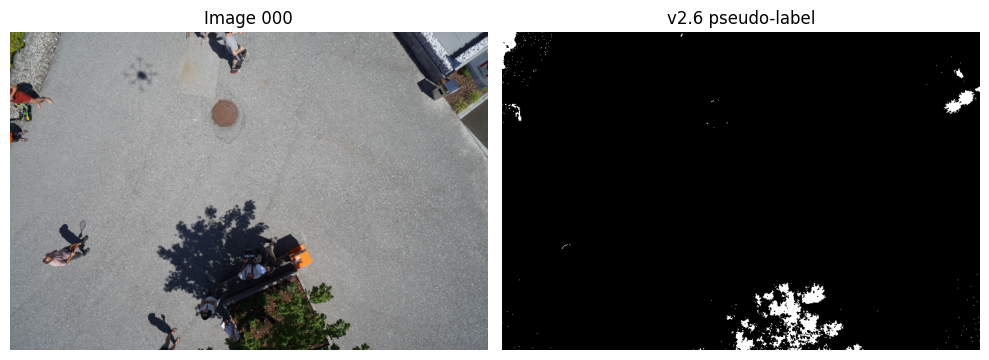

In [14]:
import os, glob, random, json, math
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


IMAGES_DIR = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
MASKS_DIR  = "/kaggle/input/pesudolabels-sobel/pseudolabels_sobel"  #this is the path to the pseudo-labels I provided

#reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#collecting matching base names present in BOTH folders (e.g., 001, 002, ...)
def list_basenames(img_dir, mask_dir):
    imgs = {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(img_dir, "*.jpg"))}
    masks= {os.path.splitext(os.path.basename(p))[0] for p in glob.glob(os.path.join(mask_dir, "*.png"))}
    common = sorted(list(imgs & masks))  # intersection
    if not common:
        raise RuntimeError("No matching base names between images (.jpg) and masks (.png). Check paths.")
    return common

BASENAMES = list_basenames(IMAGES_DIR, MASKS_DIR)
print(f"Found {len(BASENAMES)} pairs.")

#quick visual sanity check (first sample)
def quick_show_pair(name, max_side=768):
    img_p = os.path.join(IMAGES_DIR, f"{name}.jpg")
    msk_p = os.path.join(MASKS_DIR,  f"{name}.png")
    img = cv2.imread(img_p, cv2.IMREAD_COLOR)
    if img is None: raise ValueError(img_p)
    mask = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)
    if mask is None: raise ValueError(msk_p)

    #optional resize for display
    if max_side:
        h,w = img.shape[:2]; s = max(h,w)/max_side
        if s>1:
            img  = cv2.resize(img, (int(w/s), int(h/s)), interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title(f"Image {name}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(mask, cmap="gray"); plt.title("v2.6 pseudo-label"); plt.axis("off")
    plt.tight_layout(); plt.show()

quick_show_pair(BASENAMES[0])


In [15]:
class DronePseudoDataset(Dataset):
    def __init__(self, img_dir, mask_dir, basenames, out_size=(512, 512), augment=False):
        self.img_dir = img_dir
        self.mask_dir= mask_dir
        self.names = basenames
        self.out_h, self.out_w = out_size
        self.augment = augment

    def __len__(self):
        return len(self.names)

    def _read_pair(self, name):
        img = cv2.imread(os.path.join(self.img_dir, f"{name}.jpg"), cv2.IMREAD_COLOR)
        msk = cv2.imread(os.path.join(self.mask_dir,  f"{name}.png"), cv2.IMREAD_GRAYSCALE)
        if img is None or msk is None:
            raise ValueError(f"Missing pair for {name}")
        return img, msk

    def _resize_pair(self, img, msk, h, w):
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
        msk = cv2.resize(msk, (w, h), interpolation=cv2.INTER_NEAREST)
        return img, msk

    def _to_tensor(self, img, msk):
        #image: BGR uint8 -> RGB float [0,1]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
        img = np.transpose(img, (2,0,1))  # C,H,W
        #mask: 0/255 -> 0/1 float
        msk = (msk > 127).astype(np.float32)  # H,W
        msk = np.expand_dims(msk, axis=0)     # 1,H,W
        return torch.from_numpy(img), torch.from_numpy(msk)

    def _augment(self, img, msk):
        #simple, safe augmentations for binary segmentation
        if random.random() < 0.5:
            img = np.ascontiguousarray(np.fliplr(img))
            msk = np.ascontiguousarray(np.fliplr(msk))
        if random.random() < 0.5:
            img = np.ascontiguousarray(np.flipud(img))
            msk = np.ascontiguousarray(np.flipud(msk))
        #small color jitter (HSV shift)
        if random.random() < 0.3:
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
            hsv[...,0] = (hsv[...,0] + random.uniform(-5,5)) % 180
            hsv[...,1] = np.clip(hsv[...,1] * random.uniform(0.9,1.1), 0, 255)
            hsv[...,2] = np.clip(hsv[...,2] * random.uniform(0.9,1.1), 0, 255)
            img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
        return img, msk

    def __getitem__(self, idx):
        name = self.names[idx]
        img, msk = self._read_pair(name)
        if self.augment:
            img, msk = self._augment(img, msk)
        img, msk = self._resize_pair(img, msk, self.out_h, self.out_w)
        x, y = self._to_tensor(img, msk)
        return x, y, name

#split
val_ratio = 0.1
n_total = len(BASENAMES)
n_val = max(1, int(n_total * val_ratio))
n_train = n_total - n_val
train_names, val_names = random_split(BASENAMES, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
train_names = list(train_names.dataset[i] for i in train_names.indices)
val_names   = list(val_names.dataset[i] for i in val_names.indices)

train_ds = DronePseudoDataset(IMAGES_DIR, MASKS_DIR, train_names, out_size=(512,512), augment=True)
val_ds   = DronePseudoDataset(IMAGES_DIR, MASKS_DIR, val_names,   out_size=(512,512), augment=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds)


(360, 40)

In [16]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x): return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up   = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes=1, in_ch=3, base_ch=64):
        super().__init__()
        self.inc = DoubleConv(in_ch, base_ch)
        self.down1 = Down(base_ch, base_ch*2)
        self.down2 = Down(base_ch*2, base_ch*4)
        self.down3 = Down(base_ch*4, base_ch*8)
        self.down4 = Down(base_ch*8, base_ch*8)
        self.up1 = Up(base_ch*16, base_ch*4)
        self.up2 = Up(base_ch*8,  base_ch*2)
        self.up3 = Up(base_ch*4,  base_ch)
        self.up4 = Up(base_ch*2,  base_ch)
        self.outc = nn.Conv2d(base_ch, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)
        return logits

model = UNet().to(device)
sum(p.numel() for p in model.parameters())/1e6


13.391361

In [17]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
    def forward(self, logits, targets):
        #logits: (B,1,H,W), targets: (B,1,H,W) in {0,1}
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs*targets).sum(dim=(2,3)) + self.eps
        den = (probs*probs).sum(dim=(2,3)) + (targets*targets).sum(dim=(2,3)) + self.eps
        dice = num / den
        return 1.0 - dice.mean()

bce = nn.BCEWithLogitsLoss()
dice= DiceLoss()
def combo_loss(logits, targets, w_bce=0.5, w_dice=0.5):
    return w_bce * bce(logits, targets) + w_dice * dice(logits, targets)

def iou_score(logits, targets, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    preds = (probs > thr).float()
    inter = (preds*targets).sum(dim=(2,3))
    union = (preds + targets - preds*targets).sum(dim=(2,3)) + eps
    iou = (inter + eps) / union
    return iou.mean().item()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [18]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpus = torch.cuda.device_count()
print(f"Device: {device} | GPUs: {n_gpus}")

model = UNet().to(device)

#enabling multi-GPU if >1 GPU (I was using 2x T4 on Kaggle)
if n_gpus > 1:
    model = nn.DataParallel(model)
    print("Using DataParallel across", n_gpus, "GPUs")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#saves VRAM, speeds up on T4 
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

torch.backends.cudnn.benchmark = True  #speed for fixed-size inputs


Device: cuda | GPUs: 2
Using DataParallel across 2 GPUs


/tmp/ipykernel_19/3630686671.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [19]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss, running_iou = 0.0, 0.0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            logits = model(x)
            loss = combo_loss(logits, y)

        # >>> FIX: backward + step via GradScaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.detach().item() * x.size(0)
        running_iou  += iou_score(logits.detach(), y)

    n = len(loader.dataset)
    return running_loss / n, running_iou / len(loader)


@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss, running_iou = 0.0, 0.0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
            logits = model(x)
            loss = combo_loss(logits, y)

        running_loss += loss.item() * x.size(0)
        running_iou  += iou_score(logits, y)

    n = len(loader.dataset)
    return running_loss / n, running_iou / len(loader)


In [20]:
best_iou = 0.0
epochs = 25

# ---training history ---
history = {
    "epoch": [],
    "train_loss": [],
    "train_iou": [],
    "val_loss": [],
    "val_iou": [],
}


def _sd(m):
    #save state_dict correctly for DP/non-DP
    return m.module.state_dict() if isinstance(m, nn.DataParallel) else m.state_dict()

for epoch in range(1, epochs + 1):
    tr_loss, tr_iou = train_one_epoch(model, train_loader, optimizer)
    va_loss, va_iou = validate(model, val_loader)

    if va_iou > best_iou:
        best_iou = va_iou
        torch.save(_sd(model), "unet_best.pth")
        



    print(f"Epoch {epoch:02d} | "
          f"train_loss {tr_loss:.4f} iou {tr_iou:.4f} | "
          f"val_loss {va_loss:.4f} iou {va_iou:.4f} | "
          f"best_iou {best_iou:.4f}")
    
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_iou"].append(tr_iou)
    history["val_loss"].append(va_loss)
    history["val_iou"].append(va_iou)


/tmp/ipykernel_19/2938151671.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):
/tmp/ipykernel_19/2938151671.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler.is_enabled()):


Epoch 01 | train_loss 0.4302 iou 0.5154 | val_loss 0.4050 iou 0.5290 | best_iou 0.5290
Epoch 02 | train_loss 0.3962 iou 0.5588 | val_loss 0.4486 iou 0.5062 | best_iou 0.5290
Epoch 03 | train_loss 0.4002 iou 0.5567 | val_loss 0.3823 iou 0.5854 | best_iou 0.5854
Epoch 04 | train_loss 0.3955 iou 0.5620 | val_loss 0.3940 iou 0.5793 | best_iou 0.5854
Epoch 05 | train_loss 0.3860 iou 0.5666 | val_loss 0.3802 iou 0.5903 | best_iou 0.5903
Epoch 06 | train_loss 0.3825 iou 0.5824 | val_loss 0.3759 iou 0.6037 | best_iou 0.6037
Epoch 07 | train_loss 0.3770 iou 0.5772 | val_loss 0.3672 iou 0.6109 | best_iou 0.6109
Epoch 08 | train_loss 0.3765 iou 0.5794 | val_loss 0.4015 iou 0.5895 | best_iou 0.6109
Epoch 09 | train_loss 0.3564 iou 0.5990 | val_loss 0.3894 iou 0.6033 | best_iou 0.6109
Epoch 10 | train_loss 0.3698 iou 0.5951 | val_loss 0.3596 iou 0.6343 | best_iou 0.6343
Epoch 11 | train_loss 0.3563 iou 0.6077 | val_loss 0.4582 iou 0.5323 | best_iou 0.6343
Epoch 12 | train_loss 0.3688 iou 0.6030 | v

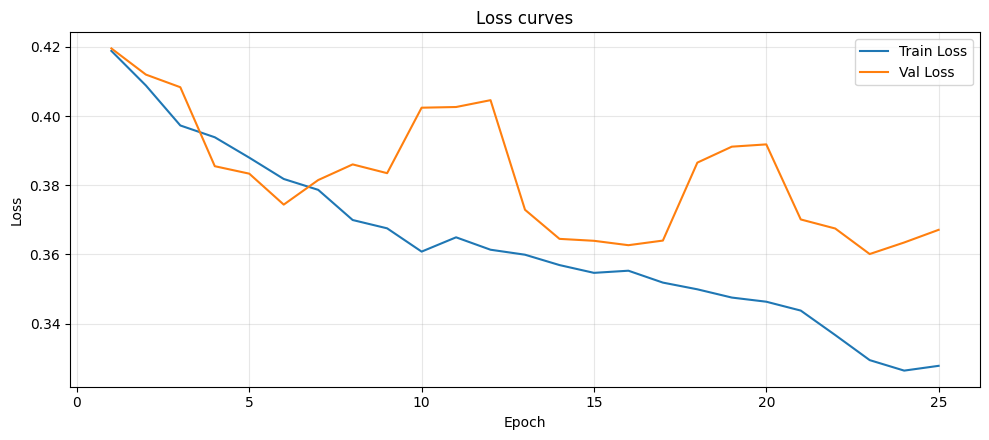

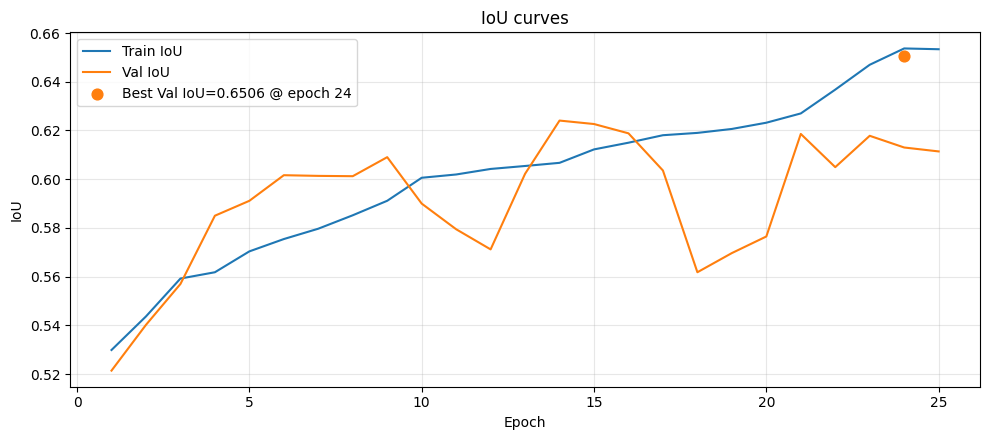

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt

PLOT_DIR = "./plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def _smooth(y, k=1):
    """Moving average semplice (k=1 = nessun smoothing)."""
    if k <= 1 or len(y) < 3:
        return np.asarray(y)
    k = int(k)
    pad = k // 2
    ypad = np.pad(y, (pad, pad), mode="edge")
    ker = np.ones(k, dtype=float) / k
    return np.convolve(ypad, ker, mode="valid")

epochs = history["epoch"]
tr_loss = np.array(history["train_loss"])
va_loss = np.array(history["val_loss"])
tr_iou  = np.array(history["train_iou"])
va_iou  = np.array(history["val_iou"])


SMOOTH_K = 3

plt.figure(figsize=(10,4.5))
plt.plot(epochs, _smooth(tr_loss, SMOOTH_K), label="Train Loss")
plt.plot(epochs, _smooth(va_loss,  SMOOTH_K), label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss curves")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "loss_curves.png"), dpi=150)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(epochs, _smooth(tr_iou, SMOOTH_K), label="Train IoU")
plt.plot(epochs, _smooth(va_iou,  SMOOTH_K), label="Val IoU")
# evidenzia il best val IoU
best_idx = int(np.argmax(va_iou))
plt.scatter([epochs[best_idx]], [va_iou[best_idx]], s=60, marker='o', color='tab:orange',
            label=f"Best Val IoU={va_iou[best_idx]:.4f} @ epoch {epochs[best_idx]}")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.title("IoU curves")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "iou_curves.png"), dpi=150)
plt.show()


/tmp/ipykernel_19/510618269.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


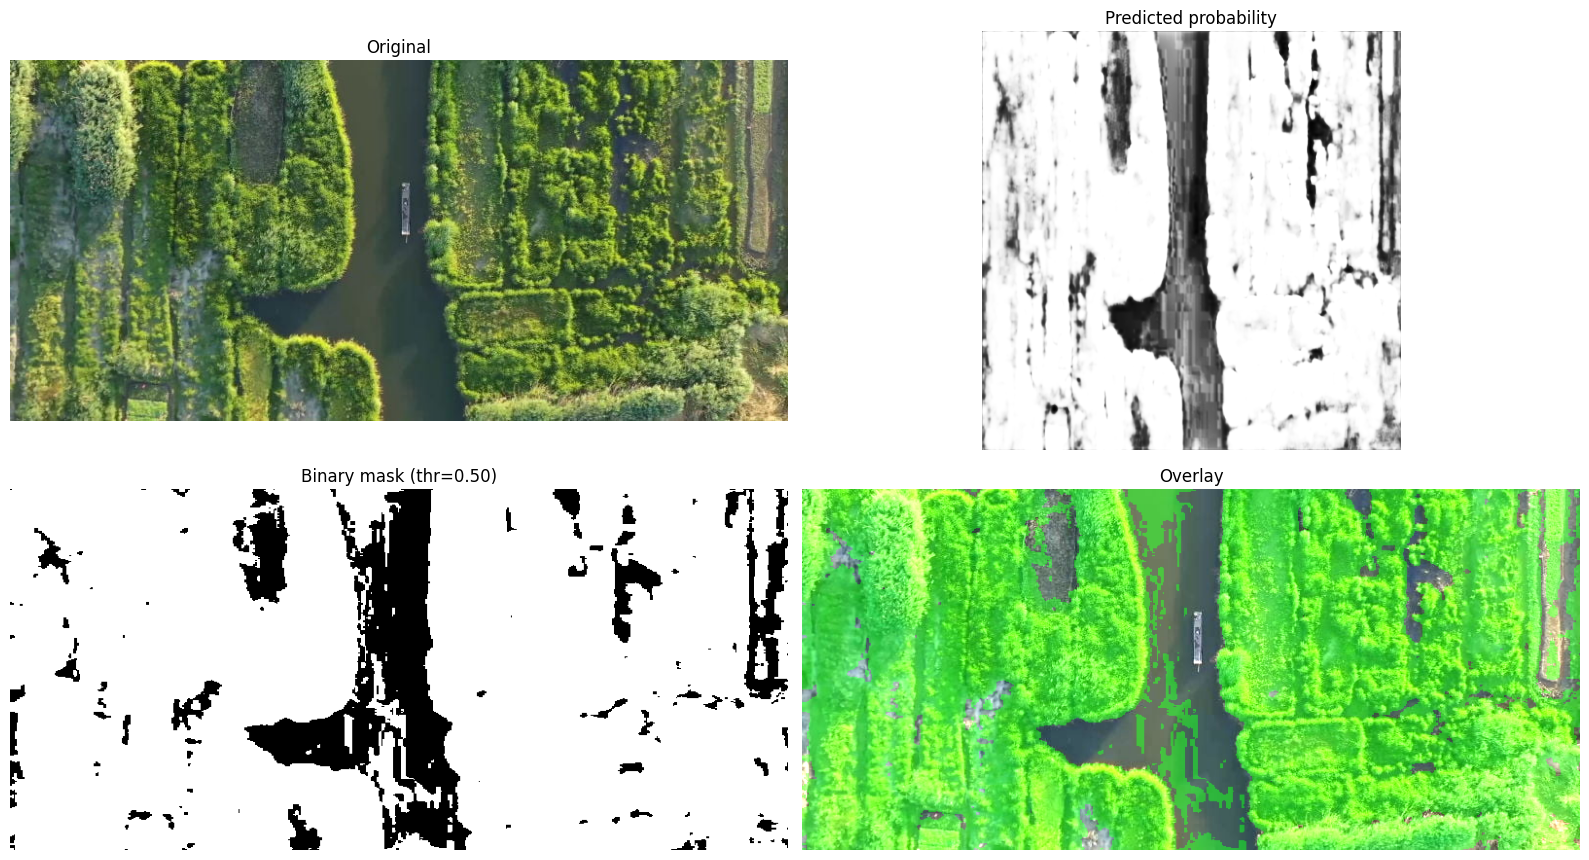

In [22]:
import os, cv2, numpy as np, torch, torch.nn as nn
import matplotlib.pyplot as plt


torch.save(_sd(model), "unet_last.pth")

#building a fresh model and loading the best weights (fallback to last unet if best not found)
infer_model = UNet().to(device)
ckpt_path = "unet_best.pth" if os.path.exists("unet_best.pth") else "unet_last.pth"
state = torch.load(ckpt_path, map_location=device)
if any(k.startswith("module.") for k in state.keys()):
    state = {k.replace("module.", "", 1): v for k, v in state.items()}
infer_model.load_state_dict(state, strict=True)
infer_model.eval()

#Inference function
def infer_image(model, img_path: str, out_size=(512, 512), thr: float = 0.5, save_dir: str = "./inference_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"Cannot read {img_path}")
    H0, W0 = bgr.shape[:2]

    #resize for training size
    bgr_rs = cv2.resize(bgr, (out_size[1], out_size[0]), interpolation=cv2.INTER_AREA)
    rgb = cv2.cvtColor(bgr_rs, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = torch.from_numpy(np.transpose(rgb, (2, 0, 1))).unsqueeze(0).to(device)

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        logits = model(x)
        prob = torch.sigmoid(logits)[0, 0].float().cpu().numpy() 

    mask_net = (prob > thr).astype(np.uint8) * 255                       
    mask_u8  = cv2.resize(mask_net, (W0, H0), interpolation=cv2.INTER_NEAREST) 

    overlay = bgr.copy()
    overlay[mask_u8 > 127] = (0, 255, 0)
    vis = cv2.addWeighted(bgr, 1.0, overlay, 0.45, 0)

    base = os.path.splitext(os.path.basename(img_path))[0]
    out_prob = os.path.join(save_dir, f"{base}_prob.png")
    out_mask = os.path.join(save_dir, f"{base}_mask.png")
    out_ovl  = os.path.join(save_dir, f"{base}_overlay.png")
    cv2.imwrite(out_prob, (prob * 255).astype(np.uint8))
    cv2.imwrite(out_mask, mask_u8)
    cv2.imwrite(out_ovl,  vis)

    #quick show
    plt.figure(figsize=(16,9))
    plt.subplot(2,2,1); plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(2,2,2); plt.imshow(prob, cmap="gray"); plt.title("Predicted probability"); plt.axis("off")
    plt.subplot(2,2,3); plt.imshow(mask_u8, cmap="gray"); plt.title(f"Binary mask (thr={thr:.2f})"); plt.axis("off")
    plt.subplot(2,2,4); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.title("Overlay"); plt.axis("off")
    plt.tight_layout(); plt.show()

    return {"prob_path": out_prob, "mask_path": out_mask, "overlay_path": out_ovl}

#general img test
NEW_IMG_PATH = "/kaggle/input/drone-river/qualita-foto-drone-dji-mini-2.jpg"
_ = infer_image(infer_model, NEW_IMG_PATH, out_size=(512, 512), thr=0.5, save_dir="./inference_outputs")


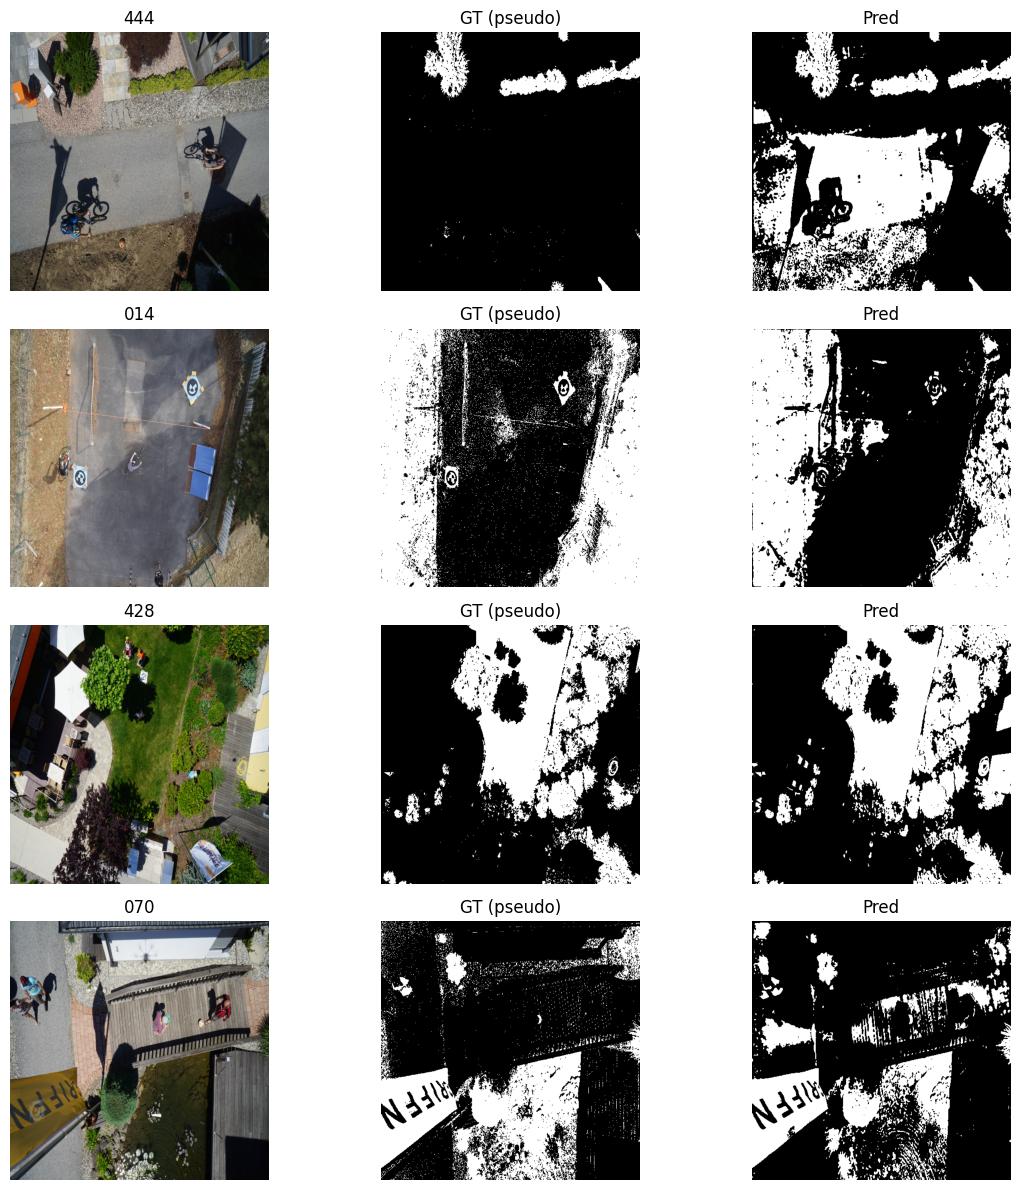

In [23]:
@torch.no_grad()
def visualize_batch(model, loader, max_images=4, thr=0.5):
    model.eval()
    x, y, names = next(iter(loader))
    x = x.to(device); y = y.to(device)
    logits = model(x); probs = torch.sigmoid(logits)
    preds = (probs > thr).float().cpu().numpy()
    imgs  = x.cpu().numpy()
    gts   = y.cpu().numpy()

    b = min(max_images, imgs.shape[0])
    plt.figure(figsize=(12, 3*b))
    for i in range(b):
        rgb = np.transpose(imgs[i], (1,2,0))
        gt  = gts[i,0]
        pr  = preds[i,0]
        plt.subplot(b,3,3*i+1); plt.imshow(rgb); plt.title(names[i]); plt.axis("off")
        plt.subplot(b,3,3*i+2); plt.imshow(gt, cmap="gray"); plt.title("GT (pseudo)"); plt.axis("off")
        plt.subplot(b,3,3*i+3); plt.imshow(pr, cmap="gray"); plt.title("Pred"); plt.axis("off")
    plt.tight_layout(); plt.show()

visualize_batch(model, val_loader, max_images=4)
